# Credit Card Fraud Detection

Classifying Credit card transaction as fraud or normal using kaggle credit card dataset. The data set has 31 features, 28 of which have been anonymized and are labeled V1 through V28. The remaining three features are the time and the amount of the transaction as well as whether that transaction was fraudulent or not.

In [2]:
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [3]:
data=pd.read_csv("creditcard.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

The data contains no null values in any of the columns.
There are total 284807 entries in the dataframe. 

In [5]:
print("the mean value of the transaction is: {}".format(data.Amount.mean()))
print("the maximum amount of transaction is: {}".format(data.Amount.max()))

the mean value of the transaction is: 88.34961925087359
the maximum amount of transaction is: 25691.16


Right skewed data distribution.

<IPython.core.display.Javascript object>


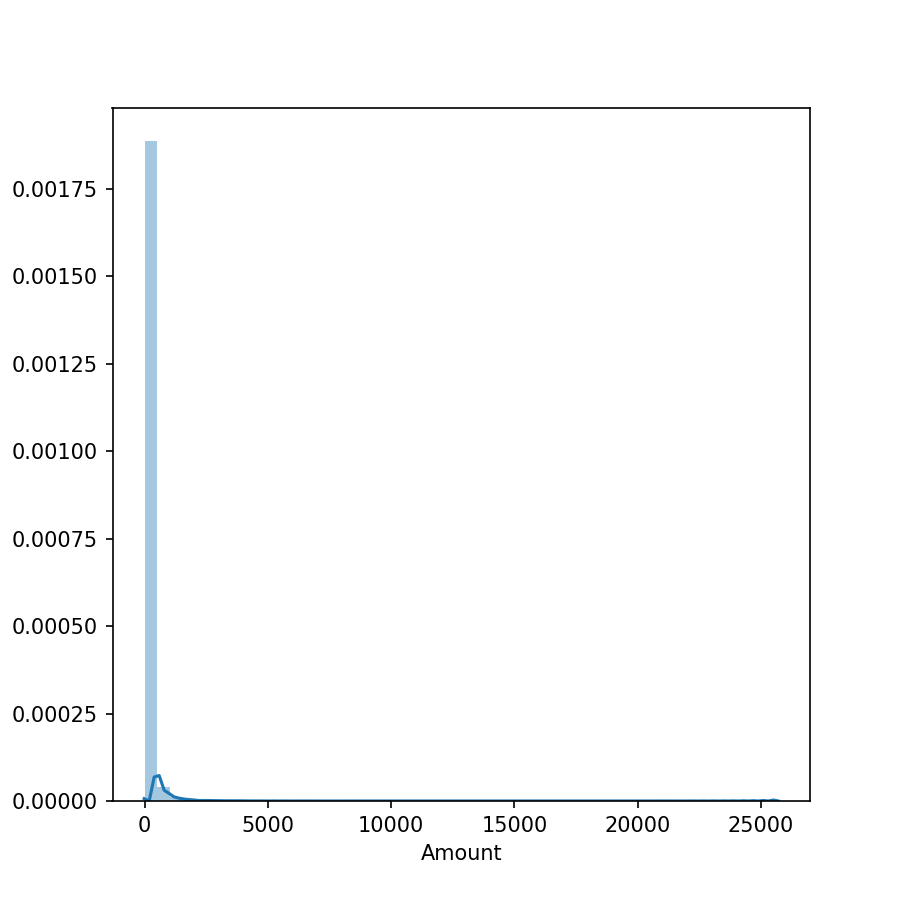

C:\Users\Praveen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [8]:
plt.figure(figsize=(6,6))
sns.distplot(data.Amount, bins=50)

The dataset is recorded for the course of two days after the first transaction. From the distribution it is noted that there is a significant drop in the transactions.

C:\Users\Praveen\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


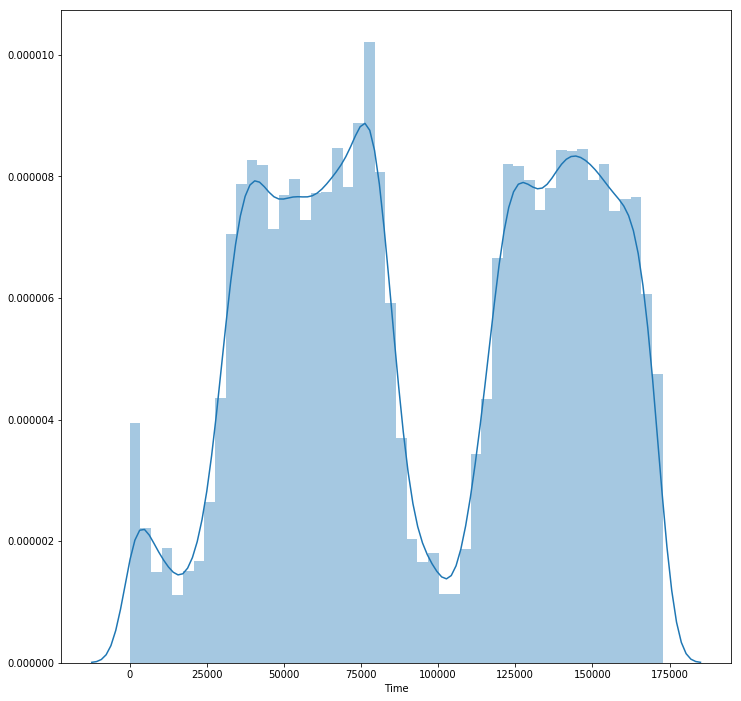

In [13]:
plt.figure(figsize=(12,12))
sns.distplot(data.Time, bins=50)

From the figure more than 99% of the entries are non-fradulent and only very less entries are fradulents.

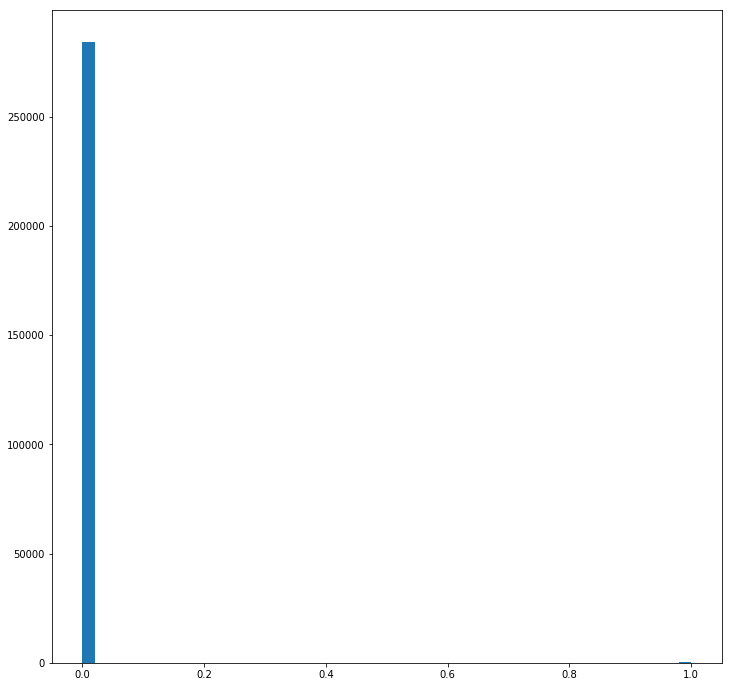

In [23]:
plt.figure(figsize=(12,12))
n, bins, patches=plt.hist(data.Class, bins=50)

Correlation of feature varibles with the class variables.

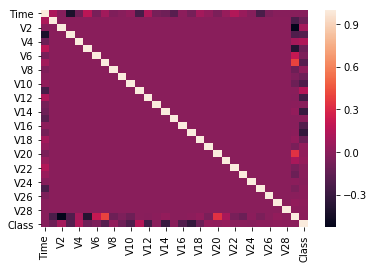

In [24]:
%matplotlib inline
corr = data.corr(method="pearson")
sns.heatmap(corr)


We can find that there are some varibles that strongly correlated with the class label. This might be due to PCA and it seem to less significant considering the large variables.

Time and amount features have not been centred and scaled as the other features are scaled.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
#scaling time
scaled_time = scaler.fit_transform(data[['Time']])
flat_list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list1)

In [10]:
#scaling the amount column
scaled_amount = scaler2.fit_transform(data[['Amount']])
flat_list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(flat_list2)

In [11]:
#concatenating newly created columns w original df
data = pd.concat([data, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)
data.drop(columns=['Time','Amount'],inplace=True)
data.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
199474,-0.461039,-0.321174,1.219952,-3.131184,-0.236845,-0.350055,-0.022975,-0.016661,-2.169031,0.438617,...,-0.310744,-0.407154,0.426972,0.736620,-0.135007,0.006804,0.045242,0,-0.333239,0.803805
235441,-1.616804,0.960221,0.263798,-0.390262,0.001487,-0.856146,0.393509,0.378272,-0.066447,-0.757840,...,0.471255,-0.360369,0.064059,1.088584,0.816010,-0.927913,-0.413030,0,-0.303813,1.128223
17181,1.059811,-0.007698,0.371489,1.310547,-0.196684,0.137261,-0.051529,0.173293,0.159265,0.054840,...,-0.032484,-0.092434,0.016530,0.592371,-0.330581,0.024346,0.009521,0,-0.192147,-1.396369
33058,-0.965436,-0.319877,3.054259,1.924234,-0.699757,0.865321,-0.628261,0.533568,0.922631,-0.663460,...,0.761090,0.088448,0.455932,-0.160611,-0.117537,0.210350,0.162017,0,-0.043018,-1.215924
96391,-1.059327,1.121756,2.574838,2.115119,-0.226979,0.487532,-0.064955,0.452604,-0.693507,0.054703,...,0.470462,0.009159,0.423368,-0.414264,-0.142711,-0.240495,-0.142379,0,-0.353229,-0.612025


In [12]:
fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])
sampled_normal=normal.sample(n=fraud.shape[0])
print(fraud.shape[0])
print(normal.shape[0])
print("sampled_normal: {}".format(sampled_normal.shape[0]))

492
284315
sampled_normal: 492


In [13]:
sampled_data=pd.concat((fraud,sampled_normal))
sampled_data.reset_index(inplace=True)
sampled_data.head()

,index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,42700,-8.440284,6.147653,-11.683706,6.702780,-8.155839,-3.716264,-12.407313,5.626571,-6.232161,...,-0.282597,0.008068,0.403858,-0.018788,0.522722,0.792691,0.067790,1,-0.232247,-1.128912
1,223366,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,-2.032638,...,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,1,-0.349231,1.022155
2,144104,-3.365265,2.928541,-5.660999,3.891160,-1.840375,-1.800887,-5.558679,2.402322,-2.848923,...,-0.102501,-0.606283,-0.743165,0.096319,-0.135060,1.238695,0.099824,1,-0.349231,-0.188465
3,14211,-17.275191,10.819665,-20.363886,6.046612,-13.465033,-4.166647,-14.409448,11.580797,-4.073856,...,-1.208096,-0.726839,0.112540,1.119193,-0.233189,1.684063,0.503740,1,0.046539,-1.464786
4,108708,-3.170818,0.185735,-3.399852,3.761155,-2.148047,-1.598944,-2.519565,1.316215,-2.400106,...,-0.041080,0.904395,0.180016,0.049970,-0.257100,0.859282,0.225924,1,1.351555,-0.500776


<IPython.core.display.Javascript object>


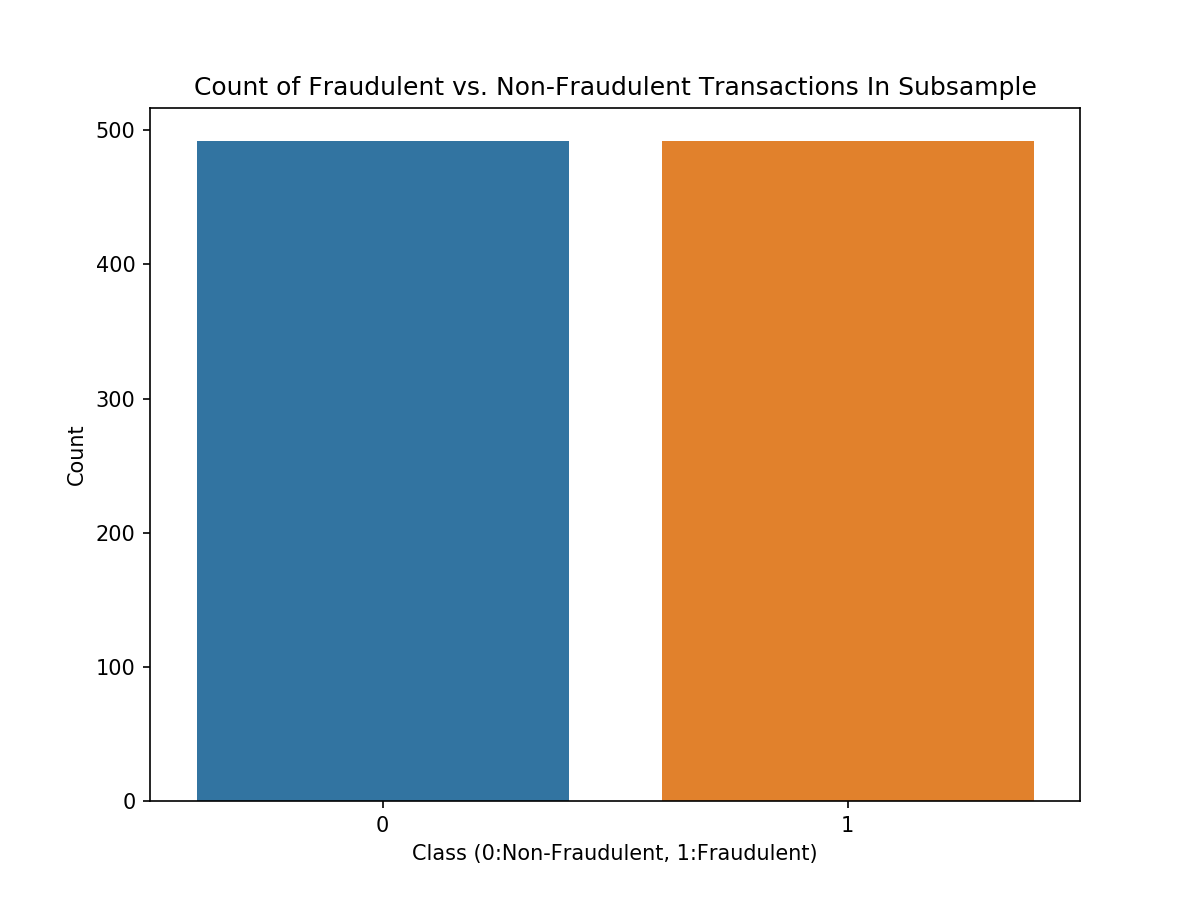

Text(0.5,0,'Class (0:Non-Fraudulent, 1:Fraudulent)')

In [18]:
new_counts = sampled_data.Class.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=new_counts.index, y=new_counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions In Subsample')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

Balanced dataset is created

In [19]:
y=sampled_data.Class
X=sampled_data.drop(columns=['Class'])

In [20]:
#taking a look at correlations once more
corr = sampled_data.corr()
corr = corr[['Class']]

In [21]:
#negative correlations smaller than -0.5
corr[corr.Class < -0.5]

,Class
V3,-0.564388
V9,-0.551511
V10,-0.628760
V12,-0.684028
V14,-0.749585
V16,-0.596692
V17,-0.560973


In [22]:
#positive correlations greater than 0.5
corr[corr.Class > 0.5]

,Class
V4,0.708236
V11,0.684658
Class,1.000000


<IPython.core.display.Javascript object>


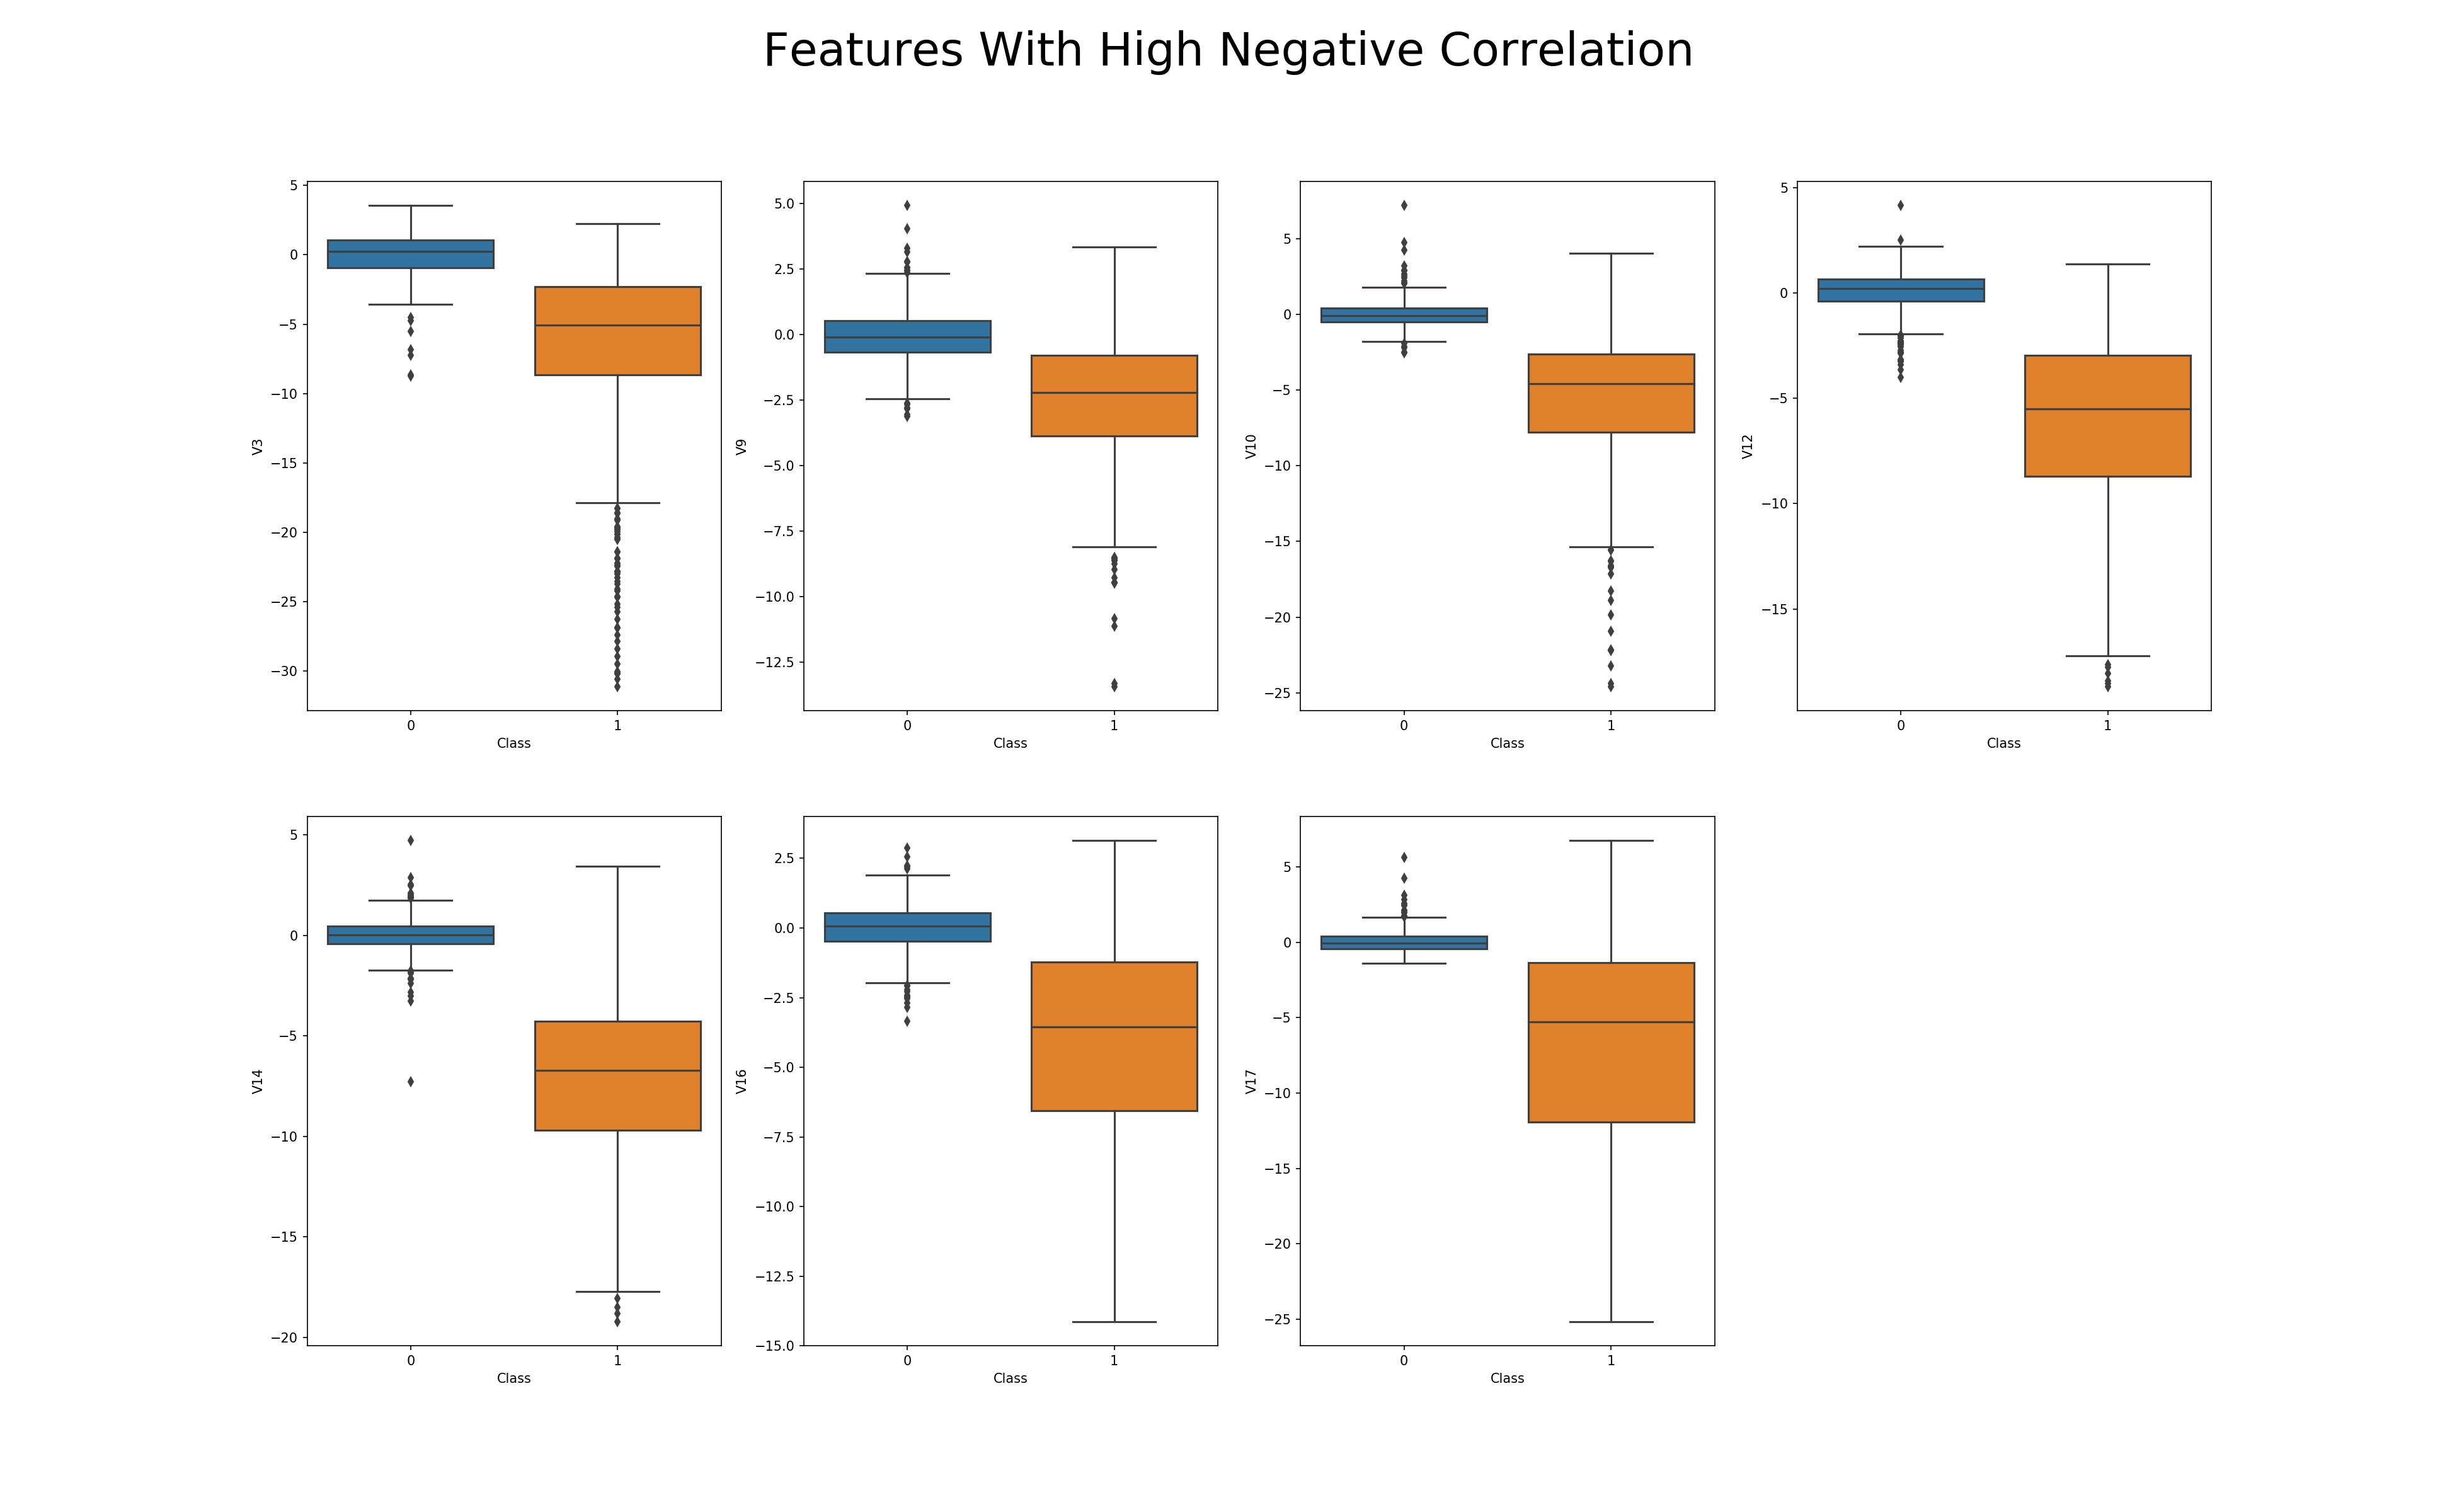

In [23]:
subsample=sampled_data
#visualizing the features w high negative correlation
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(26,16))

f.suptitle('Features With High Negative Correlation', size=35)
sns.boxplot(x="Class", y="V3", data=subsample, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=subsample, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=subsample, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=subsample, ax=axes[0,3])
sns.boxplot(x="Class", y="V14", data=subsample, ax=axes[1,0])
sns.boxplot(x="Class", y="V16", data=subsample, ax=axes[1,1])
sns.boxplot(x="Class", y="V17", data=subsample, ax=axes[1,2])
f.delaxes(axes[1,3])

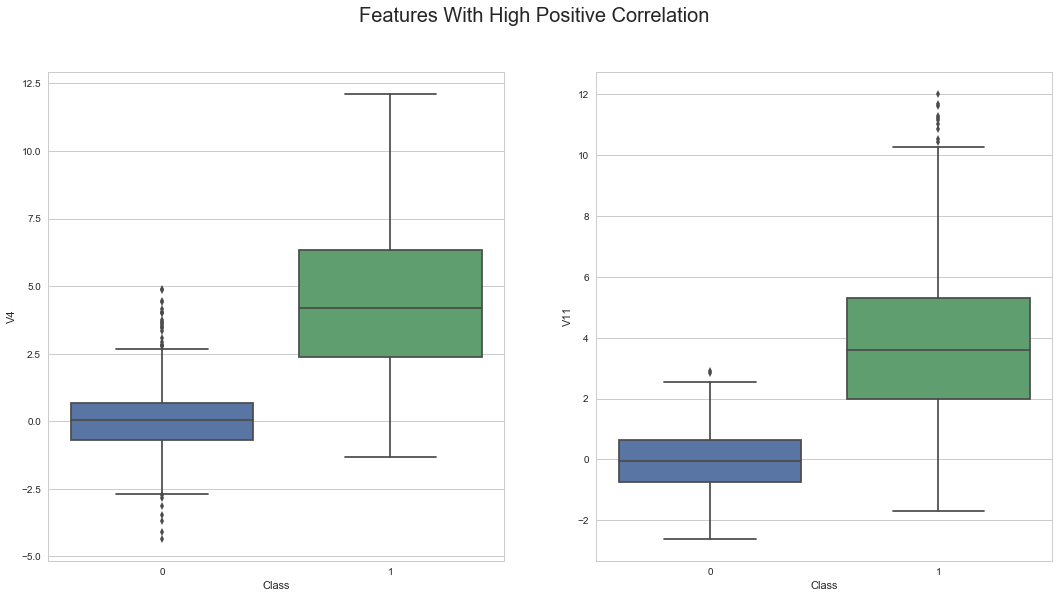

In [174]:
#visualizing the features w high positive correlation
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

f.suptitle('Features With High Positive Correlation', size=20)
sns.boxplot(x="Class", y="V4", data=subsample, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=subsample, ax=axes[1])

# Outlier Removal

In [25]:
#Only removing extreme outliers
Q1 = subsample.quantile(0.25)
Q3 = subsample.quantile(0.75)
IQR = Q3 - Q1

df2 = subsample[~((subsample < (Q1 - 2.5 * IQR)) |(subsample > (Q3 + 2.5 * IQR))).any(axis=1)]

In [26]:
len_after = len(df2)
len_before = len(subsample)
len_difference = len(subsample) - len(df2)
print('We reduced our data size from {} transactions by {} transactions to {} transactions.'.format(len_before, len_difference, len_after))

We reduced our data size from 984 transactions by 289 transactions to 695 transactions.


Classification Algorithms

In [27]:
# train test split
from sklearn.model_selection import train_test_split

X = df2.drop('Class', axis=1)
y = df2['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

In [29]:
##Spot-Checking Algorithms

models = []

models.append(('LR', LogisticRegression()))

models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.943474 (0.034461)
KNN: 0.666682 (0.070230)
CART: 0.907549 (0.035974)
SVM: 0.596433 (0.053969)
RF: 0.959115 (0.025583)


<IPython.core.display.Javascript object>


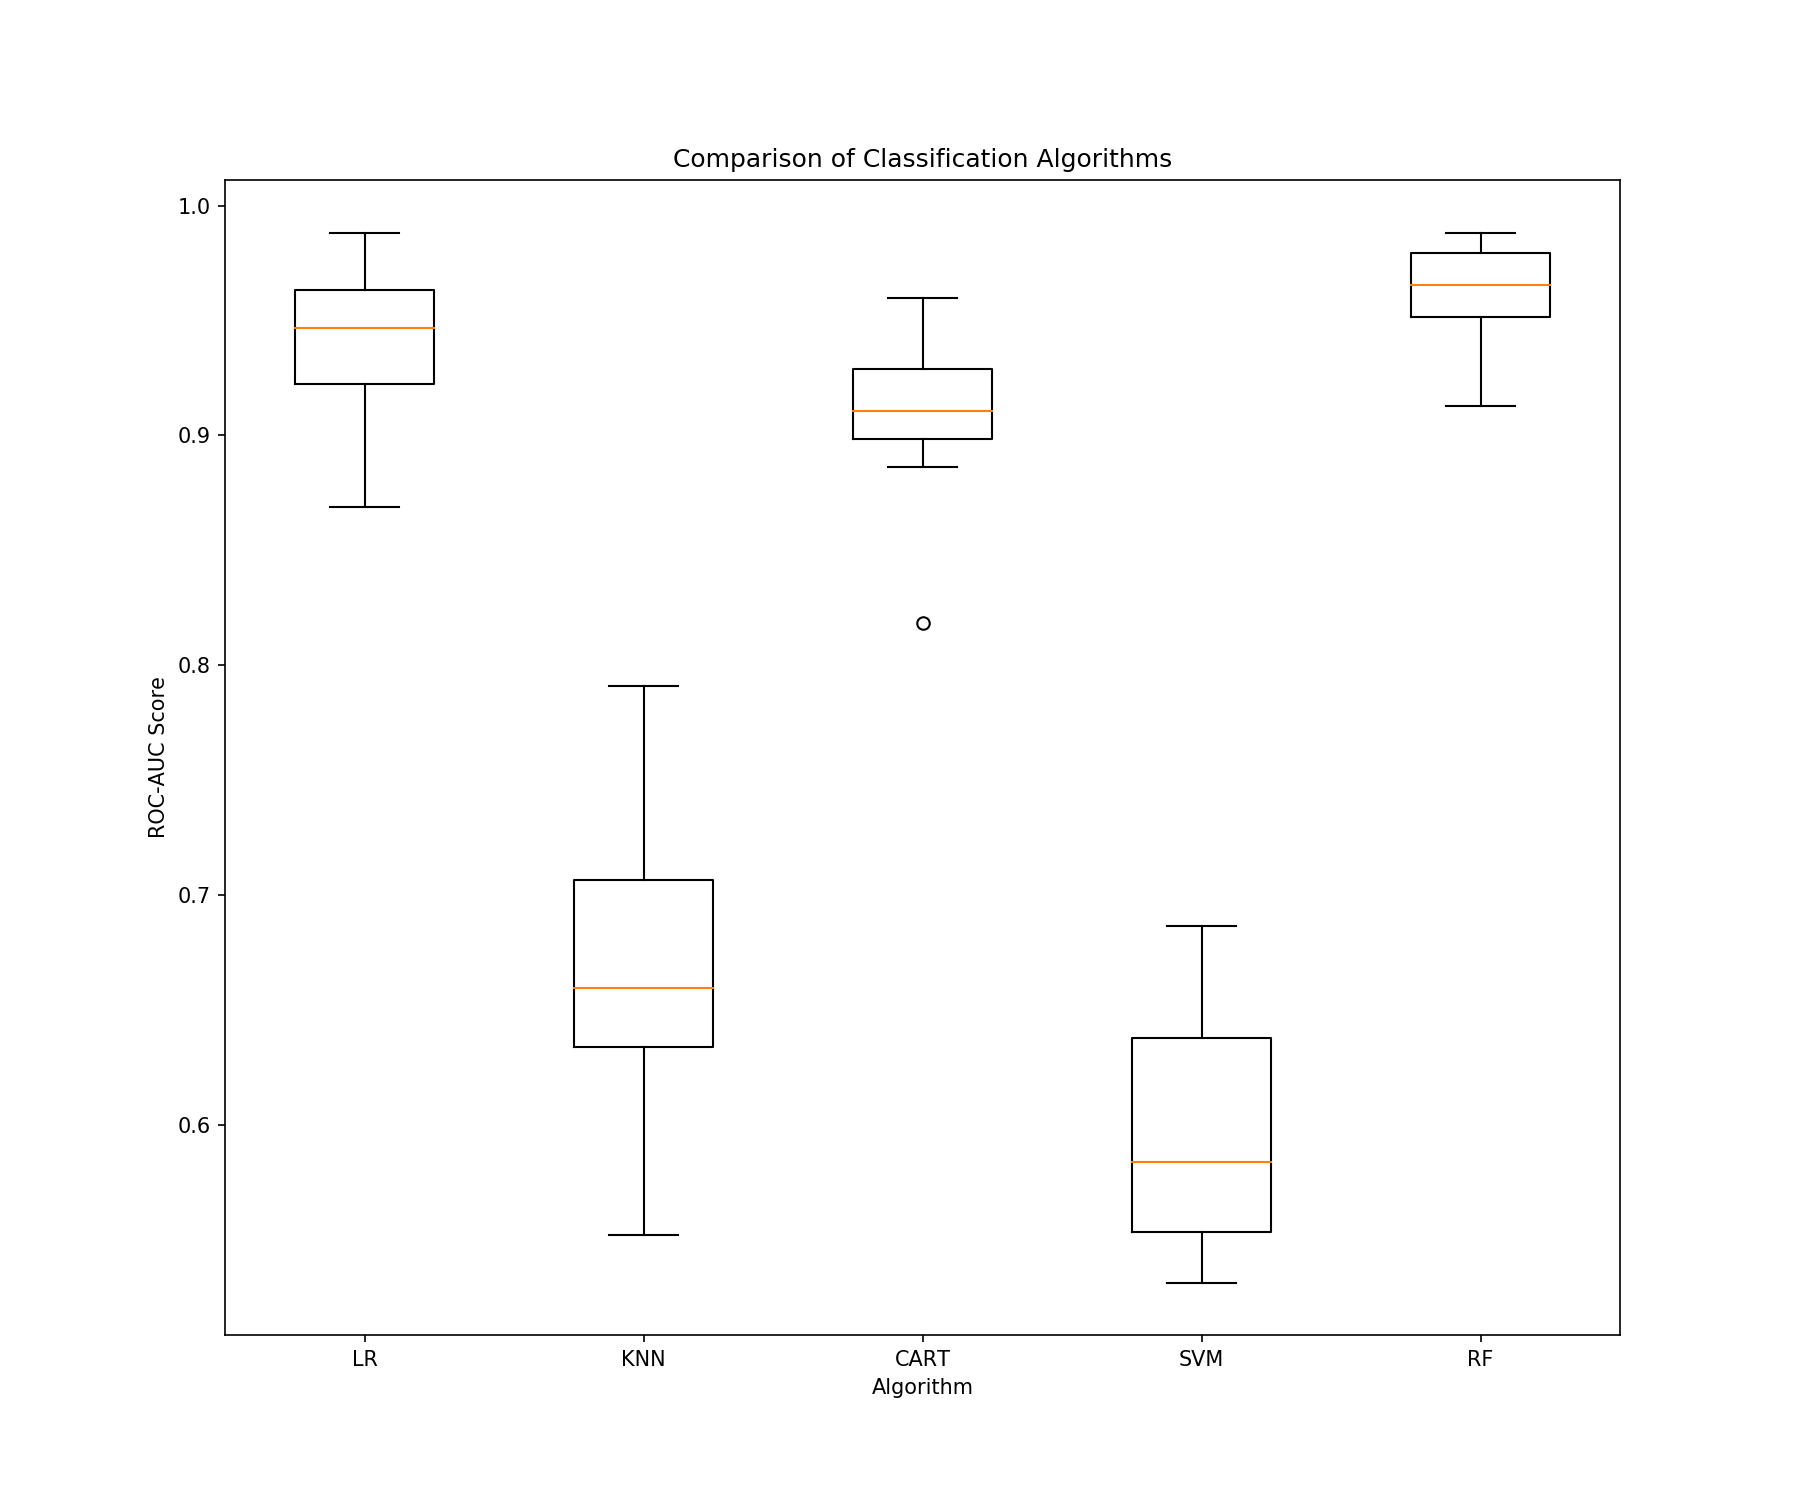

C:\Users\Praveen\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [33]:
#Compare Algorithms

fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

Random classifer performs well in our model selection with 95.9% roc_auc score with only 0.02 standard deviation.

In [48]:
def model(X_train,Y_train):
        
    clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    clf.fit(X_train, y_train) 
    return clf 

In [ ]:
model=model(X_train,y_train)

In [32]:
prediction=model.predict(X_test)

In [36]:
confusion_matrix(y_test,prediction)

array([[76,  2],
       [13, 48]], dtype=int64)

As observed from the confusion matrix out of 139 entries for prediction, 15 are misclassified in which 13 times the fraud transaction is classified as normal transaction. 

Using imbalanced dataset

In [43]:
new_data=data

In [44]:

#Create dataframes of only Fraud and Normal transactions. Also Shuffle them.
fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])
# Produce a training set of 80% of fraudulent and 80% normal transactions
X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac = 0.8)], axis = 0)
# Split remainder into testing and validation
remainder = data.loc[~data.index.isin(X_train.index)]
X_test = remainder.loc[~remainder.index.isin(X_test.index)]

# Create labels
y_train = X_train.Class
y_test = X_test.Class

X_train = X_train.drop(['Class'], axis=1)
#X_train_ = X_train_.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)


In [46]:
X_test.shape

(56933, 30)

In [49]:
model=model(X_train,y_train)

In [54]:
pred=model.predict(X_test)
confusion_matrix(y_test,pred)

array([[56826,     9],
       [   45,    53]], dtype=int64)

In [55]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,pred)

0.9990515166950626

Even thought the model returns 99% accuracy, the confusion matrix says nearly 50% entries are misclassified as a normal transaction when the imbalanced data is used. 